In [1]:
%pip install gymnasium gym matplotlib numpy pandas 

  Using cached gymnasium-1.2.0-py3-none-any.whl.metadata (9.9 kB)
  Using cached gym-0.26.2.tar.gz (721 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached matplotlib-3.10.5-cp313-cp313-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached numpy-2.3.2-cp313-cp313-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached pandas-2.3.1-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (91 kB)
  Using cached cloudpickle-3.1.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached typing_extensions-4.14.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl.metadata (558 bytes)
  Using cached gym_notices-0.1.0-py3-none-any.whl.metadata (1.2 kB)
  Using cached contourpy-1.3.3-cp313-cp313-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-an

In [2]:
# imports
import gymnasium as gym
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager

In [3]:
# actions
LEFT, DOWN, RIGHT, UP = 0,1,2,3

# import the frozen lake gym environment
name = 'FrozenLake-v1'
env = gym.make(name, is_slippery=False) # warning: setting slippery=True results in very complex environment dynamics where the optimal solution does not make sense to humans!
# env.seed(742)
# env.action_space.seed(742)

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Updated helper function to draw the frozen lake
def plot(env, V, policy, col_ramp=1, dpi=175, draw_vals=False):
    # Access unwrapped environment
    inner_env = env.unwrapped

    nrow = inner_env.nrow
    ncol = inner_env.ncol
    desc = inner_env.desc
    nS = env.observation_space.n

    plt.rcParams['figure.dpi'] = dpi
    plt.rcParams.update({'axes.edgecolor': (0.32, 0.36, 0.38)})
    plt.rcParams.update({'font.size': 4 if nrow == 8 else 7})
    plt.figure(figsize=(3, 3))

    plt.imshow(1 - V.reshape(nrow, ncol)**col_ramp, cmap='gray', interpolation='none', clim=(0, 1))
    ax = plt.gca()
    ax.set_xticks(np.arange(ncol) - .5)
    ax.set_yticks(np.arange(nrow) - .5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    for s in range(nS):
        x = s % nrow
        y = s // ncol
        a = policy[s]
        gray = np.array((0.32, 0.36, 0.38))
        tile = desc[y][x]

        if tile == b'G':
            plt.text(x - 0.45, y - 0.3, 'goal', color=(0.75, 0.22, 0.17), fontname='Sans', weight='bold')
            continue
        if a[0] > 0.0:
            plt.arrow(x, y, float(a[0]) * -0.84, 0.0, color=gray + 0.2 * (1 - V[s]), head_width=0.1, head_length=0.1)  # left
        if a[1] > 0.0:
            plt.arrow(x, y, 0.0, float(a[1]) * 0.84, color=gray + 0.2 * (1 - V[s]), head_width=0.1, head_length=0.1)   # down
        if a[2] > 0.0:
            plt.arrow(x, y, float(a[2]) * 0.84, 0.0, color=gray + 0.2 * (1 - V[s]), head_width=0.1, head_length=0.1)   # right
        if a[3] > 0.0:
            plt.arrow(x, y, 0.0, float(a[3]) * -0.84, color=gray + 0.2 * (1 - V[s]), head_width=0.1, head_length=0.1)  # up

        if tile == b'F':
            plt.text(x - 0.45, y - 0.3, 'ice', color=(gray * V[s]), fontname='Sans')
        elif tile == b'S':
            plt.text(x - 0.45, y - 0.3, 'start', color=(0.21, 0.51, 0.48), fontname='Sans', weight='bold')

        if draw_vals and V[s] > 0:
            vstr = '{0:.1e}'.format(V[s]) if nrow == 8 else '{0:.6f}'.format(V[s])
            plt.text(x - 0.45, y + 0.45, vstr, color=(gray * V[s]), fontname='Sans')

    plt.grid(color=(0.42, 0.46, 0.48), linestyle=':')
    ax.set_axisbelow(True)
    ax.tick_params(color=(0.42, 0.46, 0.48), which='both',
                   top=False, left=False, right=False, bottom=False)
    plt.show()


In [5]:
def random_epsilon_greedy_policy(Q, epsilon, state, nA):
    A = np.ones(nA, dtype=float) * epsilon / nA
    best_action = np.argmax(Q[state])
    A[best_action] += (1.0 - epsilon)
    return A

# Fully random approach

In [6]:
Q = np.zeros([env.observation_space.n, env.action_space.n])
n_s_a = np.zeros([env.observation_space.n, env.action_space.n])
num_episodes = 100000
epsilon = 1
stats = 0.0

for episode in range(num_episodes):
    state, _ = env.reset()
    done = False
    results_list = []
    result_sum = 0.0
    while not done:
        action = env.action_space.sample()
        new_state, reward, done, _, _ = env.step(action)
        results_list.append((state, action))
        result_sum += reward
        state = new_state
    
    for (state, action) in results_list:
        n_s_a[state, action] += 1.0
        alpha = 1.0 / n_s_a[state, action]
        Q[state, action] += alpha * (result_sum - Q[state, action])

    stats += result_sum
    if episode % 500 == 0 and episode is not 0:
        print(f"success: {stats/episode}, epsilon: {epsilon}")

print(f"success: {stats/episode}, epsilon: {epsilon}")

env.close()

<>:25: SyntaxWarning: "is not" with 'int' literal. Did you mean "!="?
<>:25: SyntaxWarning: "is not" with 'int' literal. Did you mean "!="?
/tmp/ipykernel_129888/3501126198.py:25: SyntaxWarning: "is not" with 'int' literal. Did you mean "!="?
  if episode % 500 == 0 and episode is not 0:


success: 0.02, epsilon: 1
success: 0.015, epsilon: 1
success: 0.014, epsilon: 1
success: 0.0155, epsilon: 1
success: 0.0144, epsilon: 1
success: 0.014, epsilon: 1
success: 0.014857142857142857, epsilon: 1
success: 0.01425, epsilon: 1
success: 0.014, epsilon: 1
success: 0.0142, epsilon: 1
success: 0.013818181818181818, epsilon: 1
success: 0.013, epsilon: 1
success: 0.012615384615384615, epsilon: 1
success: 0.012857142857142857, epsilon: 1
success: 0.013466666666666667, epsilon: 1
success: 0.013625, epsilon: 1
success: 0.013647058823529411, epsilon: 1
success: 0.013666666666666667, epsilon: 1
success: 0.01431578947368421, epsilon: 1
success: 0.0147, epsilon: 1
success: 0.015047619047619048, epsilon: 1
success: 0.01509090909090909, epsilon: 1
success: 0.015304347826086957, epsilon: 1
success: 0.015, epsilon: 1
success: 0.01512, epsilon: 1
success: 0.014923076923076923, epsilon: 1
success: 0.014666666666666666, epsilon: 1
success: 0.014357142857142857, epsilon: 1
success: 0.014206896551724

# Epsilon-Greedy Exploration

In [7]:
# lets just sample the maximum action from Q to show the optimal policy
def pi_star_from_Q(Q):
    done = False
    pi_star = np.zeros([env.observation_space.n, env.action_space.n])
    state, _ = env.reset() # start in top-left, = 0
    while not done:
        action = np.argmax(Q[state, :])
        pi_star[state,action] = 1
        state, reward, done, _, _ = env.step(action)
    return pi_star

<>:28: SyntaxWarning: "is not" with 'int' literal. Did you mean "!="?
<>:28: SyntaxWarning: "is not" with 'int' literal. Did you mean "!="?
/tmp/ipykernel_129888/1839504525.py:28: SyntaxWarning: "is not" with 'int' literal. Did you mean "!="?
  if episode % 50 == 0 and episode is not 0:


success: 0.0, epsilon: 0.3
success: 0.0, epsilon: 0.3
success: 0.0, epsilon: 0.3
success: 0.0, epsilon: 0.3
success: 0.0, epsilon: 0.3
success: 0.0, epsilon: 0.3
success: 0.0, epsilon: 0.3
success: 0.0, epsilon: 0.3
success: 0.0, epsilon: 0.3
success: 0.0, epsilon: 0.3
success: 0.0, epsilon: 0.3
success: 0.0, epsilon: 0.3
success: 0.0, epsilon: 0.3
success: 0.0, epsilon: 0.3
success: 0.0, epsilon: 0.3
success: 0.0, epsilon: 0.3
success: 0.0, epsilon: 0.3
success: 0.0, epsilon: 0.3
success: 0.0, epsilon: 0.3
success: 0.0, epsilon: 0.3
success: 0.0, epsilon: 0.3
success: 0.0, epsilon: 0.3
success: 0.014782608695652174, epsilon: 0.3
success: 0.0375, epsilon: 0.3
success: 0.0584, epsilon: 0.3
success: 0.07615384615384616, epsilon: 0.3
success: 0.09185185185185185, epsilon: 0.3
success: 0.11285714285714285, epsilon: 0.3
success: 0.13241379310344828, epsilon: 0.3
success: 0.148, epsilon: 0.3
success: 0.16193548387096773, epsilon: 0.3
success: 0.174375, epsilon: 0.3
success: 0.188484848484848

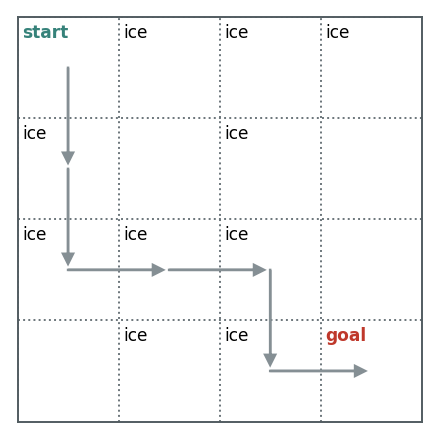

In [8]:
Q = np.zeros([env.observation_space.n, env.action_space.n])
n_s_a = np.zeros([env.observation_space.n, env.action_space.n])
num_episodes = 5000
epsilon = .3
stats = 0.0

for episode in range(num_episodes):
    state, _ = env.reset()
    done = False
    results_list = []
    result_sum = 0.0
    while not done:
        if np.random.rand() > epsilon:
            action = np.argmax(Q[state, :])
        else:
            action = env.action_space.sample()
        new_state, reward, done, _, _ = env.step(action)
        results_list.append((state, action))
        result_sum += reward
        state = new_state
    
    for (state, action) in results_list:
        n_s_a[state, action] += 1.0
        alpha = 1.0 / n_s_a[state, action]
        Q[state, action] += alpha * (result_sum - Q[state, action])

    stats += result_sum
    if episode % 50 == 0 and episode is not 0:
        print(f"success: {stats/episode}, epsilon: {epsilon}")

print(f"success: {stats/episode}, epsilon: {epsilon}")

env.close()

if (stats/episode) > 0: 
    plot(env, np.zeros_like(Q[:,0]), pi_star_from_Q(Q))
else: 
    print('No solution Found')